In [1]:
import pandas as pd
import random
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter
from numpy import where
import numpy as np

In [2]:
def import_elliptic_data():
    df_classes = pd.read_csv("data/elliptic_txs_classes.csv")
    df_edgelist = pd.read_csv('data/elliptic_txs_edgelist.csv')
    df_features = pd.read_csv('data/elliptic_txs_features.csv', header=None)
    return df_classes,df_edgelist,df_features

In [3]:
df_classes,df_edgelist,df_features = import_elliptic_data()

In [5]:
def rename_features(df_features):
    df_features.columns =["transactionId","time_step"]+[f"local_feat_{i}" for i in range(1,94)] + [f"agg_feat_{i}" for i in range(1,73)]
    return df_features


In [6]:
df_features = rename_features(df_features)
df_features.head()

,transactionId,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [7]:
def rename_classes(df_classes):
    df_classes.replace({'class':{'1':1,'2':0,'unknown':2}},inplace=True)
    return df_classes

df_classes = rename_classes(df_classes)
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


In [8]:
def combine_dataframes(df_classes, df_features, only_labeled=True):
    df_combined = pd.merge(df_features, df_classes, left_on='transactionId', right_on='txId', how='left')
    if only_labeled == True:
        df_combined = df_combined[df_combined['class'] != 2].reset_index(drop=True)
    df_combined.drop(columns=['txId'], inplace=True)
    return df_combined

In [9]:
df_combined = combine_dataframes(df_classes, df_features,only_labeled=True)
df_combined.head()

,transactionId,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,...,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72,class
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
3,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
4,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0


In [10]:
df_combined.to_csv("elliptic_data.csv",index=False)

In [11]:
def import_elliptic_edgelist(df_edgelist, df_features):
    df_edges = df_edgelist.merge(df_features[['transactionId', 'time_step']], left_on='txId1', right_on='transactionId')
    return df_edges
df_edges = import_elliptic_edgelist(df_edgelist, df_features)
df_edges.head()

,txId1,txId2,transactionId,time_step
0,230425980,5530458,230425980,1
1,232022460,232438397,232022460,1
2,232022460,232022462,232022460,1
3,230460314,230459870,230460314,1
4,230460314,230460307,230460314,1


In [12]:
def load_elliptic_data(only_labeled=True, drop_node_id=True):
    df_classes, df_edges, df_features = import_elliptic_data()
    df_features = rename_features(df_features)
    df_classes = rename_classes(df_classes)
    df_combined = combine_dataframes(df_classes, df_features, only_labeled)

    if drop_node_id:
        X = df_combined.drop(columns=['transactionId', 'class'])
    else:
        X = df_combined.drop(columns='class')

    y = df_combined['class']

    return X, y

In [13]:
X,y = load_elliptic_data(only_labeled=True,drop_node_id=True)

In [14]:
counter = Counter(y)
print(counter)


Counter({0: 42019, 1: 4545})


In [43]:
# transform the dataset
oversample = SMOTE()
X_overSampled, y_overSampled = oversample.fit_resample(X, y)

In [44]:
counter_overSampled = Counter(y_overSampled)
print(counter_overSampled)

Counter({0: 42019, 1: 42019})


In [40]:
X.head()

,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,local_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72
0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46564 entries, 0 to 46563
Columns: 166 entries, time_step to agg_feat_72
dtypes: float64(165), int64(1)
memory usage: 59.0 MB


In [42]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [43]:
len(y)

46564

In [17]:
def test_train_split(x,y, last_time_step_train, last_time_step, timestamp_column='time_step'):
    split_timesteps = {'train': list(range(last_time_step_train + 1)),
                       'test': list(range(last_time_step_train + 1, last_time_step + 1))}

    train_test_ids_x = {'train': x[x[timestamp_column].isin(split_timesteps['train'])].index,
                      'test': x[x[timestamp_column].isin(split_timesteps['test'])].index}

    x_train = x.loc[train_test_ids_x['train']]
    x_test = x.loc[train_test_ids_x['test']]

    y_train = y.loc[train_test_ids_x['train']]
    y_test = y.loc[train_test_ids_x['test']]



    return x_train, x_test, y_train, y_test


In [18]:
def run_preprocessing_pipeline(last_time_step_train, last_time_step, only_labeled=True,
                                        drop_node_id=True):
    x, y = load_elliptic_data(only_labeled, drop_node_id)
    x_train, x_test, y_train, y_test = test_train_split(x, y,last_time_step_train,last_time_step)

    return x_train, x_test, y_train, y_test

In [41]:
n_estimators = np.linspace(50,2000,5,dtype=int)
n_estimators = [2500,3000,3500,4000]
print(n_estimators)
max_features = ['auto', 'sqrt']
print(max_features)
max_depth = [20, 50,100, 200]
min_samples_leaf = [2,4,6,8]
print(min_samples_leaf)


rf_grid = {'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_leaf':min_samples_leaf}

[2500, 3000, 3500, 4000]
['auto', 'sqrt']
[2, 4, 6, 8]


In [42]:
from sklearn.model_selection import RandomizedSearchCV


def supervised_model_cv_fit_predict(x_train, y_train, x_test, model, runs=1):
    y_preds = []

    for i in range(runs):
        random.seed(i)
        rf_model = model
        rf_grid_search = RandomizedSearchCV(estimator=rf_model,param_distributions=rf_grid,cv=5,random_state=12,n_jobs=4)
        rf_grid_search.fit(x_train, y_train)
        y_pred = rf_grid_search.predict(x_test)
        y_preds.append(y_pred)

    return y_preds,rf_grid_search.best_params_

In [21]:
def calculate_model_score(y_true, y_pred, metric):
    metric_dict = {'accuracy': accuracy_score(y_true, y_pred),
                   'f1': f1_score(y_true, y_pred, pos_label=1),
                   'f1_micro': f1_score(y_true, y_pred, average='micro'),
                   'f1_macro': f1_score(y_true, y_pred, average='macro'),
                   'precision': precision_score(y_true, y_pred),
                   'recall': recall_score(y_true, y_pred),
                    'balanced_accuracy_score': balanced_accuracy_score(y_true,y_pred),
                   'roc_auc': roc_auc_score(y_true, y_pred)}
    model_score = metric_dict[metric]
    return model_score

In [22]:
def calculate_average_score(y_test,y_preds,scoring = 'f1'):
    total_scores = []
    for y_pred in y_preds:
        score = calculate_model_score(y_test.astype('int'),y_pred,scoring)
        total_scores.append(score)
    average_score = np.mean(total_scores)
    return average_score


In [23]:
def calc_average_score_and_std_per_timestep(X_test_df, y_test, y_preds, aggregated_timestamp_column='time_step', scoring= 'f1'):
    last_train_time_step = min(X_test_df['time_step']) - 1
    last_time_step = max(X_test_df['time_step'])
    all_model_scores = []
    for y_pred in y_preds:
        model_scores = []
        for time_step in range(last_train_time_step + 1, last_time_step + 1):
            time_step_idx = np.flatnonzero(X_test_df[aggregated_timestamp_column] == time_step)
            y_true_ts = y_test.iloc[time_step_idx]
            y_pred_ts = [y_pred[i] for i in time_step_idx]
            model_scores.append(calculate_model_score(y_true_ts.astype('int'), y_pred_ts, scoring))
        all_model_scores.append(model_scores)

    avg_f1 = np.array([np.mean([f1_scores[i] for f1_scores in all_model_scores]) for i in range(15)])
    std = np.array([np.std([f1_scores[i] for f1_scores in all_model_scores]) for i in range(15)])

    return avg_f1, std


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
import numpy as np


# Import Elliptic data set and set variables
last_time_step = 49
last_time_step_train = 34
only_labeled = True

x_train, x_test, y_train, y_test = run_preprocessing_pipeline(last_time_step_train=last_time_step_train, last_time_step=last_time_step, only_labeled=only_labeled)
#y_preds_rf,best_params = supervised_model_cv_fit_predict(x_train, y_train, x_test, RandomForestClassifier(n_estimators=50,max_features=50))
y_preds_rf,best_params = supervised_model_cv_fit_predict(x_train, y_train, x_test, RandomForestClassifier())


In [34]:
best_params

{'n_estimators': 3000, 'min_samples_leaf': 3, 'max_features': 'sqrt'}

In [ ]:
x_train_over, x_test_over, y_train_over, y_test_over = test_train_split(X_overSampled, y_overSampled,last_time_step_train,last_time_step)
y_preds_rf_overSampled,best_params_overSampled = supervised_model_cv_fit_predict(x_train_over, y_train_over, x_test_over, RandomForestClassifier())
#supervised_model_cv_fit_predict(x_train_over, y_train_over, x_test_over, RandomForestClassifier(n_estimators=50,max_features=50))

In [39]:
len(y_preds_rf)

1

In [33]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
avg_f1_rf_ts, std_rf_ts = calc_average_score_and_std_per_timestep(x_test, y_test, y_preds_rf)
avg_recall_rf_ts, std_recall_ts = calc_average_score_and_std_per_timestep(x_test, y_test, y_preds_rf,scoring='recall')
#avg_recall_over_rf_ts, std_over_recall_ts = calc_average_score_and_std_per_timestep(x_test_over, y_test_over, y_preds_rf_overSampled,scoring='recall')
#avg_micro_f1_over_rf_ts, std_micro_f1_over_ts = calc_average_score_and_std_per_timestep(x_test_over, y_test_over, y_preds_rf_overSampled,scoring='f1_micro')
#avg_F1_oversampled_rf_ts, std_F1_oversampled_ts = calc_average_score_and_std_per_timestep(x_test_over, y_test_over, y_preds_rf_overSampled)
avg_micro_f1_rf_ts, std_micro_f1_ts = calc_average_score_and_std_per_timestep(x_test, y_test, y_preds_rf,scoring='f1_micro')
avg_precision_rf_ts, std_precision_ts = calc_average_score_and_std_per_timestep(x_test, y_test, y_preds_rf,scoring='precision')
#avg_precision_over_rf_ts, std_over_precision_ts = calc_average_score_and_std_per_timestep(x_test_over, y_test_over, y_preds_rf_overSampled,scoring='precision')



model_f1_ts_dict = {'Random Forest': avg_f1_rf_ts}
model_recall_ts_dict = {'Random Forest': avg_recall_rf_ts}
#model_recall_over_ts_dict = {'Random Forest': avg_recall_over_rf_ts}
#Wmodel_micro_f1_over_dict = {'Random Forest': avg_micro_f1_over_rf_ts}
model_micro_f1_dict = {'Random Forest': avg_micro_f1_rf_ts}
#model_F1_oversampled_dict = {'Random Forest': avg_F1_oversampled_rf_ts}
model_precision_ts_dict = {'Random Forest': avg_precision_rf_ts}
#Emodel_precision_over_ts_dict = {'Random Forest': avg_precision_over_rf_ts}

/Users/kalubachikonde/PycharmProjects/thesisProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kalubachikonde/PycharmProjects/thesisProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kalubachikonde/PycharmProjects/thesisProject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [35]:
avg_f1 = calculate_average_score(y_test,y_preds_rf)
print("avg_f1 :",avg_f1)
avg_acc = calculate_average_score(y_test,y_preds_rf,'accuracy')
print("avg_acc :",avg_acc)
avg_precision = calculate_average_score(y_test,y_preds_rf,'precision')
print("avg_precision :",avg_precision)

avg_f1 : 0.8260869565217391
avg_acc : 0.9803239352129574


In [50]:
avg_f1 = calculate_average_score(y_test,y_preds_rf)
print("avg_f1 :",avg_f1)
avg_acc = calculate_average_score(y_test,y_preds_rf,'accuracy')
print("avg_acc :",avg_acc)
avg_f1_oversampled = calculate_average_score(y_test_over,y_preds_rf_overSampled)
print("avg_f1_oversampled ",avg_f1_oversampled)
avg_acc_oversampled = calculate_average_score(y_test_over,y_preds_rf_overSampled,'accuracy')
print("avg_acc_oversampled :",avg_acc_oversampled)

avg_f1 : 0.8059048446455795
avg_acc : 0.9773945210957807
avg_f1_oversampled  0.862803898378142
avg_acc_oversampled : 0.9052624697653137


In [137]:
model_micro_f1_over_dict.items()

dict_items([('Random Forest', array([0.99258487, 0.99237527, 0.96062992, 0.95015949, 0.950409  ,
       0.89122635, 0.94646018, 0.91908986, 0.90138445, 0.944411  ,
       0.96722178, 0.95187166, 0.7737115 , 0.60466084, 0.54302423]))])

In [ ]:
model_micro_f1_dict.values()

In [47]:
def calc_occurences_per_timestep():
    X, y = load_elliptic_data()
    X['class'] = y
    occ = X.groupby(['time_step', 'class']).size().to_frame(name='occurences').reset_index()
    return occ

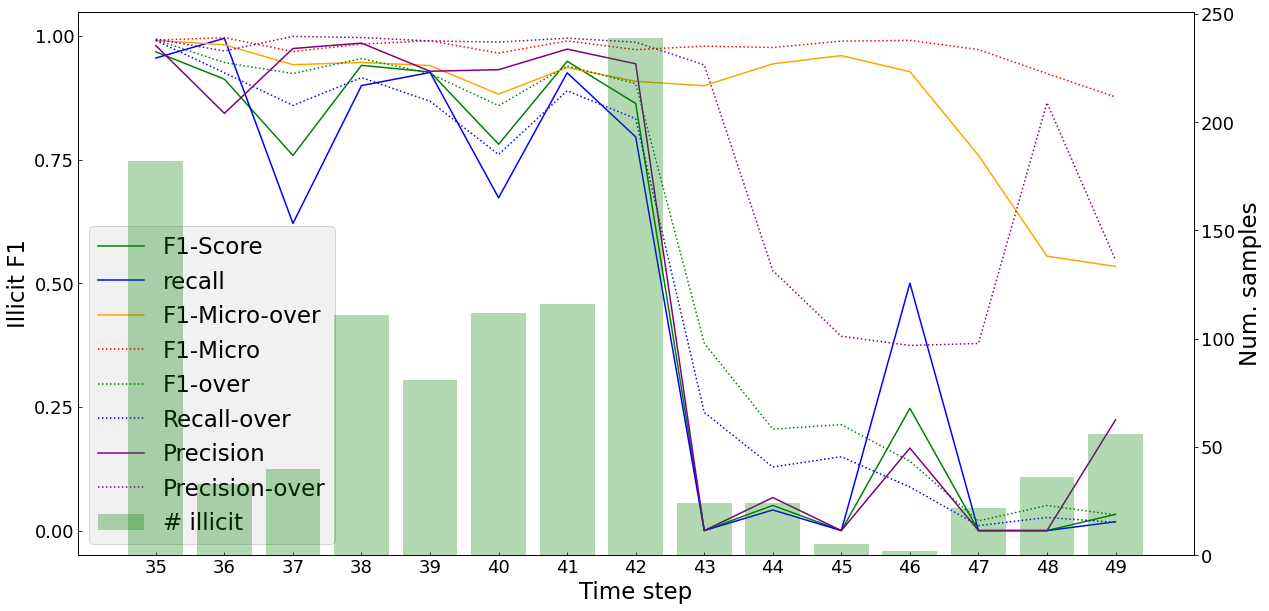

In [49]:
occ = calc_occurences_per_timestep()
illicit_per_timestep = occ[(occ['class'] == 1) & (occ['time_step'] > 34)]
timesteps = illicit_per_timestep['time_step'].unique()
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
model_std_dict = None
for key, values in model_f1_ts_dict.items():
    if key != "XGBoost":
        key = key.lower()
        ax1.plot(timesteps, values, label="F1-Score", linestyle="solid", color="green", linewidth=1.5)
        if model_std_dict is not None:
            ax1.fill_between(timesteps, values + model_std_dict[key], values - model_std_dict[key],facecolor='lightgrey', alpha=0.5)
for key, values in model_recall_ts_dict.items():
    if key != "XGBoost":
        key = key.lower()
        ax1.plot(timesteps, values, label="recall", linestyle="solid", color="blue", linewidth=1.5)
        if model_std_dict is not None:
            ax1.fill_between(timesteps, values + model_std_dict[key], values - model_std_dict[key],facecolor='grey', alpha=0.5)
for key, values in model_micro_f1_over_dict.items():
   ax1.plot(timesteps, values, label="F1-Micro-over", linestyle="solid", color="orange", linewidth=1.5)
for key, values in model_micro_f1_dict.items():
    ax1.plot(timesteps, values, label="F1-Micro", linestyle="dotted", color="red", linewidth=1.5)
for key, values in model_F1_oversampled_dict.items():
    ax1.plot(timesteps, values, label="F1-over", linestyle="dotted", color="green", linewidth=1.5)
for key, values in model_recall_over_ts_dict.items():
    ax1.plot(timesteps, values, label="Recall-over", linestyle="dotted", color="blue", linewidth=1.5)
for key, values in model_precision_ts_dict.items():
    ax1.plot(timesteps, values, label="Precision", linestyle="solid", color="purple", linewidth=1.5)
for key, values in model_precision_over_ts_dict.items():
    ax1.plot(timesteps, values, label="Precision-over", linestyle="dotted", color="purple", linewidth=1.5)





ax2.bar(timesteps, illicit_per_timestep['occurences'], color="green", alpha=0.3, label='# illicit')
ax2.get_yaxis().set_visible(True)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.grid(False)

ax1.set_xlabel('Time step', fontsize=23)
ax1.set_ylabel('Illicit F1', fontsize=23)
ax1.set_xticks(range(last_time_step_train+1,last_time_step+1))
ax1.set_yticks([0,0.25,0.5,0.75,1])
ax1.tick_params(axis='both', which='major', labelsize=18)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, fontsize=23, facecolor="#EEEEEE")
ax1.tick_params(direction='in')

ax2.set_ylabel('Num. samples', fontsize=23)
plt.show()

In [102]:
occ

,time_step,class,occurences
0,1,0,2130
1,1,1,17
2,2,0,1099
3,2,1,18
4,3,0,1268
...,...,...,...
93,47,1,22
94,48,0,435
95,48,1,36
96,49,0,420


In [103]:
illicit_per_timestep

,time_step,class,occurences
69,35,1,182
71,36,1,33
73,37,1,40
75,38,1,111
77,39,1,81
79,40,1,112
81,41,1,116
83,42,1,239
85,43,1,24
87,44,1,24


In [143]:
x = np.array([1,0,2,0,3,0,4,5,6,7,8])

In [144]:
x==0

array([False,  True, False,  True, False,  True, False, False, False,
       False, False])

In [145]:
np.nonzero(x==0)[0]

array([1, 3, 5])

In [149]:
np.where(x>=0)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [150]:
np.flatnonzero(x)

array([ 0,  2,  4,  6,  7,  8,  9, 10])

AttributeError: module 'numpy' has no attribute 'zero'